# Assignment 1 2AMM10 2023-2024

## Group: [Shash_Kas_Pim]
### Member 1: [Shashank Prabhu]
### Member 2: [Kasra Gheytuli]
### Member 3: [Pim de Wildt]

In [1]:
import os
import pandas as pd
import torch 
from torch.utils.data import Dataset, DataLoader, Sampler, ConcatDataset
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
from torchvision import transforms
import kagglehub
# add additonal imports here
import wandb
from tqdm import tqdm
import torch.nn as nn
from types import SimpleNamespace
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from collections import defaultdict
import random

class FashionDataset(Dataset):
    def __init__(self, csv_file, img_dir,column_class="articleTypeId", transform=None):
        """
        Args:
            csv_file (str): Path to the CSV file with labels.
            img_dir (str): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.df = pd.read_csv(csv_file)  # load CSV file
        self.img_dir = img_dir  # image folder path
        self.transform = transform  # image transformations
        self.targets = list(self.df[column_class].values)


    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, f"{self.df.iloc[idx]['imageId']}.jpg")  # Get image filename
        image = Image.open(img_name).convert("RGB")  # Load image

        if self.transform:
            image = self.transform(image)  # Apply transformations

        return image, self.targets[idx]

Download data with kagglehub

In [2]:
dataset_path = kagglehub.dataset_download("paramaggarwal/fashion-product-images-small")
img_dir = os.path.join(dataset_path,"images")

The different datasets can be loaded using the class `FashionDataset` which is a custon PyTorch dataset (see [Datasets & DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) for more information). Below an example of how to use the `FashionDataset` constructor as well as some visualizations. Please note that you may have to adapt the arguments to match the strucucture of your working directory.

In [3]:
dataset = FashionDataset("dataset/train.csv",img_dir)

In [4]:
dataset.df.head()

,imageId,articleTypeName,categoryName,articleTypeId,categoryId
0,35180,Backpacks,Bags,15,2
1,33585,Tshirts,Topwear,0,0
2,9464,Shirts,Topwear,1,0
3,8194,Shirts,Topwear,1,0
4,42231,Tops,Topwear,6,0


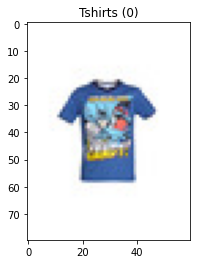

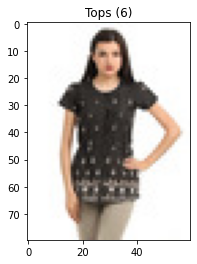

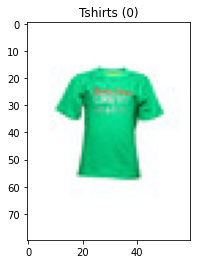

In [5]:
np.random.seed(42)
random_indices = np.random.choice(len(dataset),3)

for i in random_indices:
    img, label = dataset[i]
    plt.title(dataset.df.iloc[i]["articleTypeName"]+f" ({label.item()})")
    plt.imshow(img)
    plt.show()

## Loading different datasets

In [6]:
transform = transforms.Compose([
    transforms.Resize((80, 60)),
    transforms.ToTensor()
]) 
train_dataset = FashionDataset("dataset/train.csv",img_dir,transform=transform)
main_test_dataset =  FashionDataset("dataset/main_test.csv",img_dir,transform=transform)
new_test_dataset =  FashionDataset("dataset/new_test.csv",img_dir,transform=transform)
main_support_dataset =  FashionDataset("dataset/main_support.csv",img_dir,transform=transform)
new_support_dataset =  FashionDataset("dataset/new_support.csv",img_dir,transform=transform)
merged_test_dataset =  FashionDataset("dataset/merged_test.csv",img_dir,transform=transform) # merged corresponds to main+new
merged_support_dataset =  FashionDataset("dataset/merged_support.csv",img_dir,transform=transform)
t1_train_dataset = FashionDataset("dataset/presplit_train/trainsplit.csv",img_dir,transform=transform)
t1_val_dataset = FashionDataset("dataset/presplit_train/valsplit.csv",img_dir,transform=transform)

# datasets with categories
main_test_dataset_cat =  FashionDataset("dataset/main_test.csv",img_dir,column_class="categoryId",transform=transform)
main_support_dataset_cat =  FashionDataset("dataset/main_support.csv",img_dir,column_class="categoryId",transform=transform)


label_id_to_label_name = {i: train_dataset.df[train_dataset.df["articleTypeId"]==i]["articleTypeName"].iloc[0] for i in range(39)} 
label_id_to_label_name.update({i: new_test_dataset.df[new_test_dataset.df["articleTypeId"]==i]["articleTypeName"].iloc[0] for i in range(39,39+30)})

## Task 1

<h4>Model architecture</h4>

In [7]:
class ConvBNActivation(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, groups=1, activation=nn.Hardswish):
        super().__init__()
        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, groups=groups, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.activation = activation(inplace=True) if activation else nn.Identity()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.activation(x)
        return x

class SEBlock(nn.Module):
    """Squeeze-and-Excitation Block"""
    def __init__(self, channels, reduction_ratio=4):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        reduced_channels = max(1, channels // reduction_ratio)
        self.fc = nn.Sequential(
            nn.Linear(channels, reduced_channels),
            nn.ReLU(inplace=True),
            nn.Linear(reduced_channels, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        # Squeeze
        y = self.avg_pool(x).view(b, c)
        # Excitation
        y = self.fc(y).view(b, c, 1, 1)
        # Scale
        return x * y

class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU, use_se=False):
        super().__init__()
        self.use_se = use_se
        mid_channels = in_channels
        
        self.depthwise = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, stride=1, padding=1, groups=in_channels, bias=False),
            nn.BatchNorm2d(mid_channels),
            activation(inplace=True)
        )
        
        self.pointwise = nn.Sequential(
            nn.Conv2d(mid_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels),
            activation(inplace=True)
        )
        
        if use_se:
            self.se = SEBlock(out_channels)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        if self.use_se:
            x = self.se(x)
        return x

class AdvancedCNN(nn.Module):
    def __init__(self, nr_filters=64, activation=nn.ReLU, num_classes=39):
        super().__init__()
        self.features = nn.Sequential(
            ConvBNActivation(3, nr_filters, kernel_size=3, stride=2, activation=activation),
            
            DepthwiseSeparableConv(nr_filters, nr_filters*2, activation=activation),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            DepthwiseSeparableConv(nr_filters*2, nr_filters*4, activation=activation, use_se=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            DepthwiseSeparableConv(nr_filters*4, nr_filters*8, activation=activation, use_se=True),

            nn.AdaptiveAvgPool2d(1),
            nn.Flatten()
        )
        self.classifier = nn.Linear(nr_filters*8, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

<h4>Training functionality</h4>

In [8]:
def train(config):
    wandb.init(project='Task1_run')
    # Prepare dataloaders
    train_loader = DataLoader(t1_train_dataset, batch_size=config.batch_size, shuffle=True)
    val_loader = DataLoader(t1_val_dataset, batch_size=config.batch_size, shuffle=False)

    # Initialize model, optimizer, and loss function (criterion)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = AdvancedCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=5e-2, weight_decay=1e-4, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4)

    # Initialize patience variables
    best_val_loss = float('inf')
    wait = 0

    for epoch in range(config.epochs):
        # Training
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0
        all_train_preds, all_train_labels = [], []

        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{config.epochs} - Training', leave=False):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            train_correct += preds.eq(labels).sum().item()
            train_total += labels.size(0)
            all_train_preds.extend(preds.cpu().numpy())
            all_train_labels.extend(labels.cpu().numpy())
            
        train_loss /= train_total
        train_acc = train_correct / train_total
        balanced_train_acc = balanced_accuracy_score(all_train_labels, all_train_preds)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        all_val_preds, all_val_labels = [], []

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f'Epoch {epoch+1}/{config.epochs} - Validation', leave=False):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, preds = outputs.max(1)
                val_correct += preds.eq(labels).sum().item()
                val_total += labels.size(0)
                all_val_preds.extend(preds.cpu().numpy())
                all_val_labels.extend(labels.cpu().numpy())
            
        val_loss /= val_total
        val_acc = val_correct / val_total
        balanced_val_acc = balanced_accuracy_score(all_val_labels, all_val_preds)

        scheduler.step(val_loss)

        wandb.log({
            'train_loss': train_loss,
            'train_accuracy': train_acc,
            'train_balanced_accuracy': balanced_train_acc,
            'validation_loss': val_loss,
            'validation_accuracy': val_acc,
            'validation_balanced_accuracy': balanced_val_acc
        })

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f'saved_models/Task1_classifier_newrun.pth')
        else:
            patience_counter += 1
            if patience_counter >= config.patience:
                print('Early stopping triggered.')
                break

    wandb.finish()

default_config = SimpleNamespace(
    batch_size=1024,
    epochs=500,
    patience=10
)

# Uncomment to train
# train(default_config)

<h4>Testing functionality</h4>

In [9]:
def test(config, verbose=True):
    # Prepare dataloader
    test_loader = DataLoader(main_test_dataset, batch_size=config.batch_size, shuffle=False)

    # Initialize model (load params from saved file from training)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = AdvancedCNN()
    model.load_state_dict(torch.load('saved_models/Task1_classifier.pth'))
    model = model.to(device)

    model.eval()
    test_correct, test_total = 0, 0
    all_test_preds, all_test_labels = [], []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f'Testing', leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            _, preds = outputs.max(1)
            test_correct += preds.eq(labels).sum().item()
            test_total += labels.size(0)
            all_test_preds.extend(preds.cpu().numpy())
            all_test_labels.extend(labels.cpu().numpy())
            
    test_acc = test_correct / test_total
    balanced_test_acc = balanced_accuracy_score(all_test_labels, all_test_preds)

    if verbose:
        print(
            f"Test accuracy: {round(test_acc, 3)}",
            f"\nTest balanced accuracy: {round(balanced_test_acc, 3)}"
        )

# Uncomment to test
test(default_config)

Test accuracy: 0.86 
Test balanced accuracy: 0.802


## Task 2

<h4>Additional functionality for training</h4>

In [10]:
# Create episodic sampler class
class EpisodicSampler(Sampler):
    def __init__(self, labels, num_episodes, n_way, k_shot, q_queries):
        self.labels = labels
        self.num_episodes = num_episodes
        self.n_way = n_way
        self.k_shot = k_shot
        self.q_queries = q_queries

        self.class_to_idx = defaultdict(list)
        for idx, label in enumerate(labels):
            self.class_to_idx[label].append(idx)
    
    def __iter__(self):
        for ep in range(self.num_episodes):
            episode_idx = []
            classes = random.sample(list(self.class_to_idx.keys()), self.n_way)
            for cls in classes:
                indices = random.sample(self.class_to_idx[cls], self.k_shot + self.q_queries)
                episode_idx.extend(indices)
            yield episode_idx
    
    def __len__(self):
        return self.num_episodes

# Create prototypical loss function
def prototypical_loss(model, support, query, support_labels, query_labels):
    # Encode
    support_embeddings = model(support)
    query_embeddings = model(query)
    
    # "Episode-local" index mapping for class labels
    classes = torch.unique(support_labels)
    n_way = len(classes)
    class_to_idx = {c.item(): i for i, c in enumerate(classes)}
    support_idx = torch.tensor([class_to_idx[c.item()] for c in support_labels],
                               device=support_labels.device, dtype=torch.long)
    query_idx = torch.tensor([class_to_idx[c.item()] for c in query_labels],
                             device=query_labels.device, dtype=torch.long)

    # Compute prototypes
    prototypes = torch.stack([
        support_embeddings[support_idx == i].mean(dim=0) for i in range(n_way)
    ])

    # Compute distances and loss
    dists = torch.cdist(query_embeddings, prototypes).pow(2)  # (Q, N_way)
    logits = -dists
    loss_fn = nn.CrossEntropyLoss()
    loss = loss_fn(logits, query_idx)
    return loss

<h4>Training functionality</h4>

In [11]:
def train2(config):
    # Set sampler parameters
    all_labels = [label for _, label in train_dataset]
    k_shot = config.k_shot
    q_queries = config.q_queries
    sampler = EpisodicSampler(labels = all_labels, 
                            num_episodes = config.episodes_per_epoch,
                            n_way = config.n_way,
                            k_shot = k_shot,
                            q_queries= q_queries
                            )

    # Initialize loader for training
    train_loader = DataLoader(train_dataset, batch_sampler=sampler)

    # Set training parameters
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    protonet = AdvancedCNN(num_classes=39).to(device)
    optimizer = torch.optim.Adam(protonet.parameters(), lr=1e-3)
    num_epochs = config.max_epochs

    wandb.init(project="Task2_run")
    best_loss = float('inf')
    wait = 0

    # Training loop
    for epoch in range(num_epochs):
        protonet.train()
        total_loss = 0

        for episode in train_loader:
            images, labels = episode
            images, labels = images.to(device), labels.to(device)

            # Split into support and query sets
            support_images = []
            support_labels = []
            query_images = []
            query_labels = []

            unique_labels = torch.unique(labels)
            label_map = {label.item(): idx for idx, label in enumerate(unique_labels)}

            for cls in unique_labels:
                cls_indices = (labels == cls).nonzero(as_tuple=True)[0]
                cls_indices = cls_indices[torch.randperm(len(cls_indices))]  # shuffle
                support_idx = cls_indices[:k_shot]
                query_idx = cls_indices[k_shot:k_shot + q_queries]

                support_images.append(images[support_idx])
                support_labels.extend([label_map[cls.item()]] * k_shot)
                query_images.append(images[query_idx])
                query_labels.extend([label_map[cls.item()]] * q_queries)
            
            # Prep sets for actual training
            support_images = torch.cat(support_images)
            query_images = torch.cat(query_images)
            support_labels = torch.tensor(support_labels, device=device)
            query_labels = torch.tensor(query_labels, device=device)

            # Train step
            optimizer.zero_grad()
            loss = prototypical_loss(protonet, support_images, query_images, support_labels, query_labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        
        epoch_loss = total_loss/config.episodes_per_epoch
        wandb.log({"loss": epoch_loss})

        if epoch_loss < best_loss:
            wait = 0
            best_loss = epoch_loss
            torch.save(protonet.state_dict(), f'saved_models/Task2_protonet_newrun.pth')
        else:
            wait += 1
            if wait >= config.patience:
                print('Early stopping triggered.')
                break

    wandb.finish()

default_config = SimpleNamespace(
    k_shot=20,
    q_queries=10,
    episodes_per_epoch=100,
    n_way=10,
    max_epochs=500,
    patience=10
)

# Uncomment to train
#train2(default_config)

<h4>Additional testing functionality</h4>

In [12]:
def get_prototypes(model, support_loader, device):
    model.eval()
    support_embeddings = []
    support_labels = []

    with torch.no_grad():
        for images, labels in support_loader:
            images, labels = images.to(device), labels.to(device)
            emb = model(images)
            support_embeddings.append(emb)
            support_labels.append(labels)

    support_embeddings = torch.cat(support_embeddings)
    support_labels = torch.cat(support_labels)

    prototypes = []
    prototype_labels = []
    for c in torch.unique(support_labels):
        class_mask = support_labels == c
        proto = support_embeddings[class_mask].mean(dim=0)
        prototypes.append(proto)
        prototype_labels.append(c)
    
    prototypes = torch.stack(prototypes)
    prototype_labels = torch.tensor(prototype_labels)

    return prototypes, prototype_labels

def classify_queries(model, query_loader, prototypes, prototype_labels, device):
    model.eval()
    predictions = []
    true_labels = []
    prototype_labels = prototype_labels.to(device)

    with torch.no_grad():
        for images, labels in query_loader:
            images = images.to(device)
            emb = model(images)
            dists = torch.cdist(emb, prototypes).pow(2)  # [B, N]
            pred_indices = torch.argmin(dists, dim=1)
            preds = prototype_labels[pred_indices]

            predictions.append(preds.cpu())
            true_labels.append(labels)

    predictions = torch.cat(predictions)
    true_labels = torch.cat(true_labels)
    return predictions, true_labels

<h4>Testing functionality</h4>

In [15]:
def test2(config):
    # Initialize loaders for testing
    support_loader = DataLoader(config.support_dataset, batch_size=512, shuffle=False)
    query_loader = DataLoader(config.query_dataset, batch_size=512, shuffle=False)

    # Set training parameters
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    protonet = AdvancedCNN(num_classes=39)
    protonet.load_state_dict(torch.load("saved_models/Task2_protonet.pth"))
    protonet.to(device)

    # Compute prototypes from support set
    prototypes, proto_labels = get_prototypes(protonet, support_loader, device)

    # Classify query set data
    preds, labels = classify_queries(protonet, query_loader, prototypes, proto_labels, device)

    # Report accuracy scores
    acc = accuracy_score(labels, preds)
    balanced_acc = balanced_accuracy_score(labels, preds)
    print(f"Scenario {config.scenario_id}", f"\nAccuracy: {round(acc, 4)}", f"\nBallanced Accuracy: {round(balanced_acc, 4)}")

scenario1_config = SimpleNamespace(
    scenario_id=1,
    support_dataset=train_dataset,
    query_dataset=main_test_dataset
)

scenario2_config = SimpleNamespace(
    scenario_id=2,
    support_dataset=main_support_dataset,
    query_dataset=main_test_dataset
)

scenario3_config = SimpleNamespace(
    scenario_id=3,
    support_dataset=new_support_dataset,
    query_dataset=new_test_dataset
)

scenario4_config = SimpleNamespace(
    scenario_id=4,
    support_dataset=merged_support_dataset,
    query_dataset=merged_test_dataset
)

scenario_configs = [scenario1_config, scenario2_config, scenario3_config, scenario4_config]

# Uncomment to test
for i, scenario in enumerate(scenario_configs):
   test2(scenario)
   if i<3:
       print("")

Scenario 1 
Accuracy: 0.8142 
Ballanced Accuracy: 0.8164

Scenario 2 
Accuracy: 0.7922 
Ballanced Accuracy: 0.8072

Scenario 3 
Accuracy: 0.5982 
Ballanced Accuracy: 0.6017

Scenario 4 
Accuracy: 0.6123 
Ballanced Accuracy: 0.6167


## Task 3

<h4>Additional functionality</h4>

In [16]:
def compute_confidence_batch(topk_distances: torch.Tensor) -> torch.Tensor:
    mean_dist = topk_distances.mean(dim=1)
    confidence = 1.0 - mean_dist / 4.0
    return confidence.clamp(0.0, 1.0)

<h4>Test recommendation rates (FP and coverage)</h4>

In [17]:
def test3(threshold, top_k=3):
    support_loader = DataLoader(merged_support_dataset, batch_size=512, shuffle=False)
    query_loader = DataLoader(merged_test_dataset, batch_size=512, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    protonet = AdvancedCNN(num_classes=39)
    protonet.load_state_dict(torch.load("saved_models/Task2_protonet.pth"))
    protonet.to(device)
    protonet.eval()

    # Compute support embeddings
    support_embeddings = []
    support_labels = []
    with torch.no_grad():
        for images, labels in support_loader:
            images, labels = images.to(device), labels.to(device)
            emb = nn.functional.normalize(protonet(images), p=2, dim=1)
            support_embeddings.append(emb)
            support_labels.append(labels)
    support_embeddings = torch.cat(support_embeddings)
    support_labels = torch.cat(support_labels)

    # Query phase
    confidences = []
    query_recommendations = []
    query_labels = []
    with torch.no_grad():
        for images, labels in query_loader:
            images, labels = images.to(device), labels.to(device)
            query_embeddings = nn.functional.normalize(protonet(images), p=2, dim=1)
            dists = torch.cdist(query_embeddings, support_embeddings).pow(2)

            topk_dists, topk_idx = dists.topk(top_k, largest=False)
            query_recommendations.append(support_labels[topk_idx])
            confidences.append(compute_confidence_batch(topk_dists))
            query_labels.append(labels)

    confidences = torch.cat(confidences)
    query_recommendations = torch.cat(query_recommendations)
    query_labels = torch.cat(query_labels)

    # Filter based on threshold
    filter_mask = confidences >= threshold
    filtered_recommendations = query_recommendations[filter_mask]
    filtered_labels = query_labels[filter_mask]

    # Compute error rate and coverage
    hits = torch.tensor([true in recommendation for true, recommendation in zip(filtered_labels, filtered_recommendations)], dtype=bool)
    fp = (~hits).sum().item()
    fpr = fp / len(query_labels)  # error over all queries
    coverage = filter_mask.float().mean().item()  # % of recommendations shown

    return fpr, coverage

In [ ]:
def plot3(save_figure=False):
    threshold_range = np.linspace(start=0.73, stop=1.0, num=28)
    FPR_list, coverage_list = [], []

    for t in threshold_range:
        FPR, coverage = test3(threshold=t)
        FPR_list.append(round(FPR*100, 2))
        coverage_list.append(round(coverage*100, 2))
    
    fig, ax1 = plt.subplots()
    ax1.plot(coverage_list, FPR_list, color='b', label="FPR vs. Coverage")
    ax1.set_xlabel("Coverage %")
    ax1.set_ylabel("Error rate % (FPR)", color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.grid(True, which="both")
    ax1.set_title("Error rate over coverage")

    ax2 = ax1.twinx()
    ax2.set_ylabel("Threshold (0.01 intervals)", color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    fig.tight_layout()
    if save_figure:
        plt.savefig("Task3_plot.png", dpi=300, bbox_inches="tight")
    plt.show()
    
# Uncomment to run
plot3(save_figure=True)

In [ ]:
def find_threshold_for_target_error(target_error_rate=0.10, top_k=3):
    threshold_range = np.linspace(start=0.5, stop=1.0, num=50)
    best_threshold = None
    best_error = float('inf')
    best_coverage = 0.0

    for t in threshold_range:
        fpr, coverage = test3(threshold=t, top_k=top_k)
        if abs(fpr - target_error_rate) < abs(best_error - target_error_rate):
            best_error = fpr
            best_threshold = t
            best_coverage = coverage

    print(f"  Target Error Rate: {target_error_rate * 100:.1f}%")
    print(f"→ Best Threshold: {best_threshold:.3f}")
    print(f"→ Actual Error Rate: {best_error * 100:.2f}%")
    print(f"→ Coverage: {best_coverage * 100:.2f}%")
    return best_threshold, best_error, best_coverage

# Uncomment to find the best threshold
find_threshold_for_target_error(0.10)

## Task 4

In [20]:
# your solution
# datasets: first 10 classes of train_dataset and main_test_dataset

from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
protonet = AdvancedCNN(num_classes=39).to(device)
protonet.load_state_dict(torch.load("saved_models/Task2_protonet.pth", map_location=device))

# protonet.eval()

<All keys matched successfully>

In [22]:
def extract_embeddings(dataset, to_cpu=True, class_ids=None, batch_size=256):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    embs, labs = [], []
    for imgs, labels in loader:
        if class_ids is not None:
            mask = torch.isin(labels, torch.tensor(class_ids))
            imgs = imgs[mask]
            labels = labels[mask]
            if imgs.numel() == 0:
                continue
        with torch.no_grad():
            e = protonet(imgs.to(device))
        embs.append(e.cpu()) if to_cpu else embs.append(e)
        labs.append(labels)
    return torch.cat(embs), torch.cat(labs)

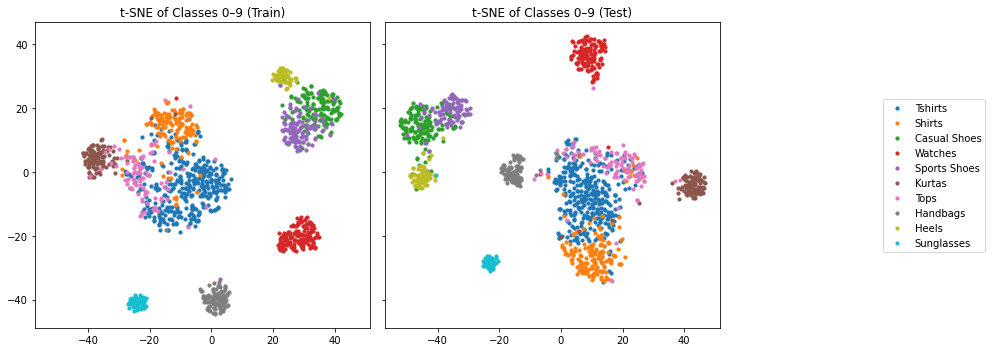

In [23]:
first10 = list(range(10))

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# Store handles and labels for a shared legend
all_handles = []
all_labels = []

for idx, (split_name, ds) in enumerate([("Train", main_support_dataset), ("Test", main_test_dataset)]):
    E, L = extract_embeddings(ds, class_ids=first10)
    tsne = TSNE(n_components=2, init="random", random_state=42)
    Z = tsne.fit_transform(E.numpy())
    
    ax = axes[idx]
    for c in first10:
        mask = (L.numpy() == c)
        label_name = label_id_to_label_name.get(c, f"Class {c}")
        scatter = ax.scatter(Z[mask, 0], Z[mask, 1], s=10, label=label_name)
        if idx == 0:
            all_handles.append(scatter)
            all_labels.append(label_name)
    ax.set_title(f"t-SNE of Classes 0–9 ({split_name})")

fig.legend(all_handles, all_labels, loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize='medium')
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

<Figure size 432x432 with 0 Axes>

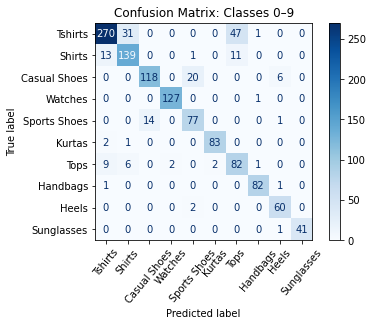

In [24]:
# --- Step 2: Confusion Matrix ---
E_sup, L_sup = extract_embeddings(main_support_dataset, class_ids=first10)
prototypes = torch.stack([ E_sup[L_sup==c].mean(0) for c in first10 ]).to(device)
E_test, L_test = extract_embeddings(main_test_dataset, class_ids=first10)
with torch.no_grad():
    dists = torch.cdist(E_test.to(device), prototypes).cpu()
preds = dists.argmin(dim=1).numpy()
true_labels = L_test.numpy()
class_names = [label_id_to_label_name[c] for c in first10]
cm = confusion_matrix(true_labels, preds, labels=first10)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
plt.figure(figsize=(6,6))
disp.plot(cmap="Blues", xticks_rotation=50)
plt.title("Confusion Matrix: Classes 0–9")
plt.show()

(-0.5, 59.5, 79.5, -0.5)

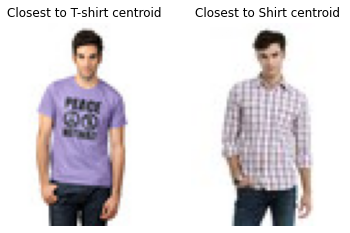

In [25]:
# --- Step 3: Shirt vs T-shirt ---
combined_ds = ConcatDataset([train_dataset, main_test_dataset])

filtered_samples = [(x, y) for x, y in combined_ds if y in [0, 1]]
class FilteredDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, idx):
        return self.data[idx]

    def __len__(self):
        return len(self.data)
filtered_ds = FilteredDataset(filtered_samples)
filtered_loader = DataLoader(filtered_ds, batch_size=512, shuffle=False)

prototypes, _ = get_prototypes(protonet, filtered_loader, device)
prototype0, prototype1 = prototypes[0], prototypes[1]

all_embs, all_labels = extract_embeddings(combined_ds, to_cpu=False, batch_size=512)
dists0 = torch.norm(all_embs - prototype0, dim=1)
dists1 = torch.norm(all_embs - prototype1, dim=1)

min_idx0 = torch.argmin(dists0)
min_idx1 = torch.argmin(dists1)

closest_img_to_0 = combined_ds[int(min_idx0.cpu())][0]
closest_img_to_1 = combined_ds[int(min_idx1.cpu())][0]

fig, ax = plt.subplots(1, 2)
ax[0].set_title("Closest to T-shirt centroid")
ax[0].imshow(closest_img_to_0.permute(1,2,0))
ax[0].axis("off")
ax[1].set_title("Closest to Shirt centroid")
ax[1].imshow(closest_img_to_1.permute(1,2,0))
ax[1].axis("off")

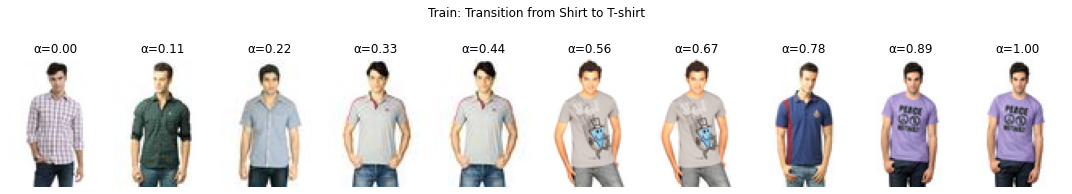

In [26]:
# Train data interpolation visualization
alphas = np.linspace(0, 1, 10)
fig, axes = plt.subplots(1, len(alphas), figsize=(15, 3))

for i, alpha in enumerate(alphas):
    probe = ((1 - alpha) * prototype1 + alpha * prototype0).unsqueeze(0)
    d = torch.norm(all_embs.cpu() - probe.cpu(), dim=1)
    idx = int(torch.argmin(d).cpu())
    img, _ = combined_ds[idx]
    
    axes[i].imshow(img.permute(1, 2, 0))
    axes[i].set_title(f"α={alpha:.2f}")
    axes[i].axis("off")

plt.suptitle("Train: Transition from Shirt to T-shirt")
plt.tight_layout()
plt.show()


In [28]:
# --- Step 4: Category-level Evaluation ---
support_loader = DataLoader(main_support_dataset_cat, batch_size=512, shuffle=False)
query_loader = DataLoader(main_test_dataset_cat, batch_size=512, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
protonet = AdvancedCNN(num_classes=39)
protonet.load_state_dict(torch.load("saved_models/Task2_protonet.pth"))
protonet.to(device)

prototypes, proto_labels = get_prototypes(protonet, support_loader, device)
preds, labels = classify_queries(protonet, query_loader, prototypes, proto_labels, device)

acc = accuracy_score(labels, preds)
bal_acc = balanced_accuracy_score(labels, preds)

print(f"Task 4 (Scenario 2 - Categories)")
print(f"Accuracy: {acc:.4f}")
print(f"Balanced Accuracy: {bal_acc:.4f}")

Task 4 (Scenario 2 - Categories)
Accuracy: 0.8723
Balanced Accuracy: 0.9162
